# Data sets
Parsing and discovery, loading.

In [1]:
#| default_exp data_sets

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

In [3]:
#| hide
from nbdev.showdoc import *


In [4]:
#| export

from typing import Dict, List

from pathlib import Path

## Data set discovery using Prefix Trees

Data sets are discovered based on being folders within the provided data set root directory which contain subdirectories that start with `cleaned_`.  

Once the data sets are discovered, we take the `cleaned_<feature>` subdirectories and use the `<feature>` as the feature name. 

Then we take the files within the `cleaned_<feature>` subdirectories and discover the ids that data set has for that feature. These do not need to be the same across features, hence all of our data getters might also return `None`.

Automagic ID discovery is done using a prefix tree, which is a data structure that allows for efficient searching of strings based on their prefixes.

In [5]:
#| export

from copy import deepcopy
import warnings

class SimplifiablePrefixTree:
    """A standard prefix tree with the ability to "simplify" itself by combining nodes with only one child.

    These also have the ability to "flatten" themselves, which means to convert all nodes at and below a certain depth into leaves on the most recent ancestor of that depth.

    Parameters
    ----------
    delimiter : str
        The delimiter to use when splitting words into characters. If empty, the words are treated as sequences of characters.
    key : str
        The key of the current node in its parent's `.children` dictionary. If empty, the node is (likely) the root of the tree.
    
    Attributes
    ----------
    key : str
        The key of the current node in its parent's `.children` dictionary. If empty, the node is (likely) the root of the tree.
    children : Dict[str, SimplifiablePrefixTree]
        The children of the current node, stored in a dictionary with the keys being the children's keys.
    is_end_of_word : bool
        Whether the current node is the end of a word. Basically, is this a leaf node?
    delimiter : str
        The delimiter to use when splitting words into characters. If empty, the words are treated as sequences of characters.
    print_spacer : str
        The string to use to indent the printed tree.
    
    Methods
    -------
    chars_from(word: str) -> List[str]
        Splits a word into characters, using the `delimiter` attribute as the delimiter.
    insert(word: str) -> None
        Inserts a word into the tree.
    search(word: str) -> bool
        Searches for a word in the tree.
    simplified() -> SimplifiablePrefixTree
        Returns a simplified copy of the tree. The original tree is not modified.
    simplify() -> SimplifiablePrefixTree
        Simplifies the tree in place.
    reversed() -> SimplifiablePrefixTree
        Returns a reversed copy of the tree, except with with `node.key` reversed versus the node in `self.children`. The original tree is not modified.
    flattened(max_depth: int = 1) -> SimplifiablePrefixTree
        Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
    _pushdown() -> List[SimplifiablePrefixTree]
        Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
    print_tree(indent=0) -> str
        Prints the tree, with indentation.
    """
    def __init__(self, delimiter: str = "", key: str = ""):
        self.key = key
        self.children: Dict[str, SimplifiablePrefixTree] = {}
        self.is_end_of_word = False
        self.delimiter = delimiter
        self.print_spacer = "++"
    
    def chars_from(self, word: str):
        return word.split(self.delimiter) if self.delimiter else word

    def insert(self, word: str):
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                node.children[char] = SimplifiablePrefixTree(self.delimiter, key=char)
            node = node.children[char]
        node.is_end_of_word = True

    def search(self, word: str) -> bool:
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                return False
            node = node.children[char]
        return node.is_end_of_word
    
    def simplified(self) -> 'SimplifiablePrefixTree':
        self_copy = deepcopy(self)
        return self_copy.simplify()
    
    def simplify(self):
        if len(self.children) == 1 and not self.is_end_of_word:
            child_key = list(self.children.keys())[0]
            self.key += child_key
            self.children = self.children[child_key].children
            self.simplify()
        else:
            current_keys = list(self.children.keys())
            for key in current_keys:
                child = self.children.pop(key)
                child.simplify()
                self.children[child.key] = child
        return self
    
    def reversed(self) -> 'SimplifiablePrefixTree':
        rev_self = SimplifiablePrefixTree(self.delimiter, key=self.key[::-1])
        rev_self.children = {k[::-1]: v.reversed() for k, v in self.children.items()}
        return rev_self
    
    def flattened(self, max_depth: int = 1) -> 'SimplifiablePrefixTree':
        """Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
        """
        flat_self = SimplifiablePrefixTree(self.delimiter, key=self.key)
        if max_depth == 0:
            if not self.is_end_of_word:
                warnings.warn(f"max_depth is 0, but {self.key} is not a leaf.")
            return flat_self
        if max_depth == 1:
            for k, v in self.children.items():
                if v.is_end_of_word:
                    flat_self.children[k] = SimplifiablePrefixTree(self.delimiter, key=k)
                else:
                    # flattened_children = v._pushdown()
                    for flattened_child in v._pushdown():
                        flat_self.children[flattened_child.key] = flattened_child
        else:
            for k, v in self.children.items():
                flat_self.children[k] = v.flattened(max_depth - 1)
        return flat_self
    
    def _pushdown(self) -> List['SimplifiablePrefixTree']:
        """Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
        """
        pushed_down = [
            c
            for k in self.children.values()
            for c in k._pushdown()
        ]
        for i in range(len(pushed_down)):
            pushed_down[i].key = self.key + self.delimiter + pushed_down[i].key

        if not pushed_down:
            return [SimplifiablePrefixTree(self.delimiter, key=self.key)]
        else:
            return pushed_down
            

    def __str__(self):
        # prints .children recursively with indentation
        return self.key + "\n" + self.print_tree()

    def print_tree(self, indent=0) -> str:
        result = ""
        for key, child in self.children.items():
            result +=  self.print_spacer * indent + "( " + child.key + "\n"
            result += SimplifiablePrefixTree.print_tree(child, indent + 1)
        return result


class IdExtractor(SimplifiablePrefixTree):
    """Class extending the prefix trees that incorporates the algorithm for extracting IDs from a list of file names. The algorithm is somewhat oblique, so it's better to just use the `extract_ids` method versus trying to use the prfix trees directly at the call site.
    
    The algorithm is based on the assumption that the IDs are the same across all file names, but that the file names may have different suffixes. The algorithm reverses the file names, inserts them into the tree, and then simplifes and flattens that tree in order to find the IDs as leaves of that simplified tree.

    1. Insert the file name string into the tree, but with each string **reversed**.
    2. Simplify the tree, combining nodes with only one child.
    3. There may be unexpected suffix matches for these IDs, so we flatten the tree to depth 1, meaning all children of the root are combined to make leaves.
    4. The leaves are the IDs we want to extract. However, we must reverse these leaf keys to get the original IDs, since we reversed the file names in step 1.

    TODO:
    * If we want to find IDs for files with differing prefixes instead, we should instead insert the file names NOT reversed and then NOT reverse in the last step.

    * To handle IDs that appear in the middle of file names, we can use both methods to come up with a list of potential IDs based on prefix and suffix, then figure out the "intersection" of those lists. (Maybe using another prefix tree?)

    """
    def __init__(self, delimiter: str = "", key: str = ""):
        super().__init__(delimiter, key)

    def extract_ids(self, files: List[str]) -> List[str]:
        for file in files:
            self.insert(file[::-1])
        return sorted([
            c.key for c in self
                .prefix_flattened()
                .children
                .values()
        ])
    
    def prefix_flattened(self) -> 'IdExtractor':
        return self.simplified().flattened(1).reversed()
    

In [6]:
#| test
entries = [
    '3XYZabc12',
    '3XY&abc12',
    '3XYAabc12',
    '3XYBabc12',
    'MMVQabc12',
    'NMVQabc12',
]

expected_ids = sorted([
    '3XYZ',
    '3XY&',
    '3XYA',
    '3XYB',
    'MMVQ',
    'NMVQ',
])

id_extractor = IdExtractor()

ids = id_extractor.extract_ids(entries)

for i, (expected, actual) in enumerate(zip(expected_ids, ids)):
    assert expected == actual, f"Expected {expected}, but got {actual} at index {i}"


In [7]:
#| hide
print(id_extractor)


( 2
++( 1
++++( c
++++++( b
++++++++( a
++++++++++( Z
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( &
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( A
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( B
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( Q
++++++++++++( V
++++++++++++++( M
++++++++++++++++( M
++++++++++++++++( N



In [8]:
#| hide
print(id_extractor.prefix_flattened())

abc12
( 3XYZ
( 3XY&
( 3XYA
( 3XYB
( MMVQ
( NMVQ



In [9]:
#| export

import os
import re
from typing import DefaultDict, Iterable
from collections import defaultdict
import logging

import polars as pl
import numpy as np
from pisces.utils import determine_header_rows_and_delimiter

LOG_LEVEL = logging.INFO

class DataSetObject:
    FEATURE_PREFIX = "cleaned_"

    # Set up logging
    logger = logging.getLogger(__name__)
    logger.setLevel(LOG_LEVEL)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    def __init__(self, name: str, path: Path):
        self.name = name
        self.path = path
        self.ids: List[str] = []

        # keeps track of the files for each feature and user
        self._feature_map: DefaultDict[str, Dict[str, str]] = defaultdict(dict)
        self._feature_cache: DefaultDict[str, Dict[str, pl.DataFrame]] = defaultdict(dict)
    
    @staticmethod
    def from_dict(data: Dict[str, Dict[str, pl.DataFrame]]) -> 'DataSetObject':
        """
        Instantiates a DataSetObject given a dict mapping 
        {
            feature_name: {
                id: pl.DataFrame
            }
        }
        """
        data_mock = DataSetObject("mock", Path("."))
        data_mock._feature_cache = data
        # when data = {"feature_1": {...}, "feature_2": {...}, ...}
        # data.keys() = ["feature_1", "feature_2", ...]
        data_mock._feature_map = {
            k: {
                k2: "FROM_DICTIONARY" 
                for k2 in v.keys()
            } 
            for k, v in data.items()
        }
        data_mock.ids = list(set(
            id for feature in data.values()
            for id in feature.keys()
        ))

        return data_mock
    
    @property
    def features(self) -> List[str]:
        return list(self._feature_map.keys())
    
    def __str__(self):
        return f"{self.name}: {self.path}"

    def get_feature_data(self, feature: str, id: str) -> pl.DataFrame | None:
        if (df := self._feature_cache[feature].get(id)) is None:
            file = self.get_filename(feature, id)
            if not file:
                return None
            self.logger.debug(f"Loading {file}")
            try:
                n_rows, delimiter = determine_header_rows_and_delimiter(file)
                # self.logger.debug(f"n_rows: {n_rows}, delimiter: {delimiter}")
                df = pl.read_csv(file, has_header=True if n_rows > 0 else False,
                                 skip_rows=max(n_rows-1, 0), 
                                 separator=delimiter)
            except Exception as e:
                warnings.warn(f"Error reading {file}:\n{e}")
                return None
            # sort by time when loading
            df.sort(df.columns[0])
            self._feature_cache[feature][id] = df
        return df

    def get_filename(self, feature: str, id: str) -> Path | None:
        feature_ids = self._feature_map.get(feature)
        if feature_ids is None:
            print(f"Feature {feature_ids} not found in {self.name}")
            return None
        file = feature_ids.get(id)
        if file is None:
            print(f"ID {id} not found in {self.name}")
            return None
        return self.get_feature_path(feature)\
            .joinpath(file)
    
    def get_feature_path(self, feature: str) -> Path:
        return self.path.joinpath(self.FEATURE_PREFIX + feature)
    
    def _extract_ids(self, files: List[str]) -> List[str]:
        return IdExtractor().extract_ids(files)
    
    def add_feature_files(self, feature: str, files: Iterable[str]):
        if feature not in self.features:
            self.logger.debug(f"Adding feature {feature} to {self.name}")
            self._feature_map[feature] = {}
        # use a set for automatic deduping
        deduped_ids = set(self.ids)
        extracted_ids = sorted(self._extract_ids(files))
        files = sorted(list(files))
        # print('# extracted_ids:', len(extracted_ids))
        for id, file in zip(extracted_ids, files):
            # print('adding data for id:', id, 'file:', file)
            self._feature_map[feature][id] = file
            # set.add only adds the value if it's not already in the set
            deduped_ids.add(id)
        self.ids = sorted(list(deduped_ids))
    
    def get_feature_files(self, feature: str) -> Dict[str, str]:
        return {k: v for k, v in self._feature_map[feature].items()}
    
    def get_id_files(self, id: str) -> Dict[str, str]:
        return {k: v[id] for k, v in self._feature_map.items()}
    
    def load_feature_data(self, feature: str | None, id: str | None) -> Dict[str, np.ndarray]:
        if feature not in self.features:
            raise ValueError(f"Feature {feature} not found in {self.name}")
    
    @classmethod
    def find_data_sets(cls, root: str | Path) -> Dict[str, 'DataSetObject']:
        set_dir_regex = r".*" + cls.FEATURE_PREFIX + r"(.+)"
        # this regex matches the feature directory name and the data set name
        # but doesn't work on Windows (? maybe, cant test) because of the forward slashes
        feature_dir_regex = r".*/(.+)/" + cls.FEATURE_PREFIX + r"(.+)"

        data_sets: Dict[str, DataSetObject] = {}
        for root, dirs, files in os.walk(root, followlinks=True):
            # check to see if the root is a feature directory,
            # if it is, add that feature data to the data set object,
            # creating a new data set object if necessary.
            if (root_match := re.match(feature_dir_regex, root)):
                cls.logger.debug(f"Feature directory: {root}")
                cls.logger.debug(f"data set name: {root_match.group(1)}")
                cls.logger.debug(f"feature is: {root_match.group(2)}", )
                data_set_name = root_match.group(1)
                feature_name = root_match.group(2)
                if (data_set := data_sets.get(data_set_name)) is None:
                    data_set = DataSetObject(root_match.group(1), Path(root).parent)
                    data_sets[data_set.name] = data_set
                files = [f for f in files if not f.startswith(".") and not f.endswith(".tmp")]
                data_set.add_feature_files(feature_name, files)
        
        return data_sets
    



In [10]:
#| hide
import numpy as np
x = np.array([1, 2, 3])
y = np.array([2, 4, 6])

print(np.hstack([x, y]), "\n")
print(np.vstack([x, y]), "\n")
print(np.vstack([x.reshape(-1,1), y.reshape(-1,1)]), "\n")
print(np.hstack([x.reshape(-1,1), y.reshape(-1,1)]), "\n")

[1 2 3 2 4 6] 

[[1 2 3]
 [2 4 6]] 

[[1]
 [2]
 [3]
 [2]
 [4]
 [6]] 

[[1 2]
 [2 4]
 [3 6]] 



In [11]:
#| test


psg_epoch = 30
n_epoch = 5
psg_max_time = psg_epoch * n_epoch
psg = np.array([
    [j, j % (psg_max_time // 5)]
    for i, j in enumerate(range(0, psg_max_time, psg_epoch))
])

accel_sample_rate = 0.2
accel_time = np.arange(0, psg_max_time + 1, accel_sample_rate).reshape(-1, 1)
accel_xyz = np.random.random((len(accel_time), 3))
accel = np.hstack([accel_time, accel_xyz])

test_data = {
    "accelerometer": {
        "1":  accel,
        "2": accel
    },
    "psg": {
        "1": psg,
        "2": psg
    }
}

data_set = DataSetObject.from_dict(test_data)

# Write these asserts in a flexible way, to make this test re-usable and easier to update.
# (6, 2) given numbers at time of writing
assert data_set.get_feature_data("psg", "1").shape == (n_epoch, 2)
# (755, 4)
assert data_set.get_feature_data("accelerometer", "1").shape == (1 + int((psg_max_time + 1) // 0.2), 4)

# Model preprocessing

In [12]:
#| export
from typing import Tuple
from numpy.lib.stride_tricks import as_strided
from pisces.data_sets import DataSetObject

def mask_psg_from_accel(psg: np.ndarray, accel: np.ndarray, psg_epoch: int = 30, accel_sample_rate: float | None = None) -> np.ndarray:

    acc_last_index = 0
    acc_next_index = acc_last_index
    acc_last_time = accel[acc_last_index, 0]
    acc_next_time = acc_last_time

    # at least this fraction of 1 epoch must be covered
    # both in terms of time (no gap longer than 0.5 epochs)
    # and in terms of expected number of samples in that time.
    min_epoch_fraction_covered = 0.5
    min_epoch_covered = min_epoch_fraction_covered * psg_epoch
    if accel_sample_rate is None:
        # median sample step size, if none provided
        # median to not take into account gaps!
        accel_sample_rate = np.median(np.diff(accel[:, 0]))
    min_samples_per = min_epoch_covered / accel_sample_rate

    psg_gap_indices = []

    for (psg_index, psg_sample) in enumerate(psg):
        epoch_ends = psg_sample[0] + psg_epoch

        # find the last timestamp inside the epoch
        while (acc_next_time <= epoch_ends):
            acc_next_time = accel[acc_next_index, 0]
            acc_next_index += 1
        
        # 1. check for lots of missing time
        # 2. check for very low sampling rate
        if ((acc_next_time - acc_last_time) < min_epoch_covered) \
            or (acc_next_index - acc_last_index < min_samples_per):
            psg_gap_indices.append(psg_index)

        
        # set up for next iteration
        acc_last_time = acc_next_time
        acc_last_index = acc_next_index
    
    psg[np.array(psg_gap_indices), 1] = -1

    return psg


def mask_accel_gaps(data_set: DataSetObject, accel_name: str = "accelerometer", psg_name: str = "psg") -> DataSetObject:
    failures = []
    for id in data_set.ids:
        try:
            accel = data_set.get_feature_data(accel_name, id)
            masked_psg = data_set.get_feature_data(psg_name, id)
            mask_threshold_seconds = masked_psg[:, 0].to_numpy()[1] - masked_psg[:, 0].to_numpy()[0]

            gaps = np.diff(accel[:, 0]) > mask_threshold_seconds

            # mask the psg data where the gaps are
            # by finding the timestamps in accel[:, 0] where the gaps are
            # and matching those up to the timestamps in masked_psg[:, 0]
            # and setting the corresponding rows in masked_psg to -1
            masked_psg[:, 1][np.isin(masked_psg[:, 0], accel[gaps, 0])] = -1

        except Exception as e:
            print(f"Error in {id}: {e}")
            failures.append(id)
            continue
    if failures:
        join_str = "\n - "
        # Failed to process N ids:
        # - id1
        # - id2
        print(f"Failed to process {len(failures)} ids:{join_str}{join_str.join(failures)}")


def psg_to_sleep_wake(psg: pl.DataFrame) -> np.ndarray:
    """
    * map all positive classes to 1 (sleep)
    * retain all 0 (wake) and -1 (mask) classes
    """
    return np.where(psg[:, 1] > 0, 1, psg[:, 1])

def psg_to_WLDM(psg: pl.DataFrame) -> np.ndarray:
    """
    * map all positive classes as follows:
        - 1, 2 => 1 (light sleep)
        - 3, 4 => 2 (deep sleep)
        - 5 => 3 (REM)
    * retain all 0 (wake) and -1 (mask) classes
    """
    return np.piecewise(
        psg[:, 1].to_numpy(),
        [
            psg[:, 1] < 0,
            psg[:, 1] == 0,
            psg[:, 1] < 3,
            psg[:, 1] < 5,
            psg[:, 1] == 5,
        ], 
        [
            psg[:, 1], # < 0: keep this as is
            0,  # == 0: wake 
            1,
            2,
            3
        ])

def get_activity_X_PSG_y(data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
    activity_0 = data_set.get_feature_data("activity", id)
    psg_0 = data_set.get_feature_data("psg", id)

    if activity_0 is None or psg_0 is None:
        return None

    # trim the activity and psg data to both end when the 0th column (time) of either ends
    end_time = min(activity_0[-1, 0], psg_0[-1, 0])
    activity_0 = activity_0.filter(activity_0[:, 0] <= end_time)
    psg_0 = psg_0.filter(psg_0[:, 0] <= end_time)

    X = activity_0[:, 1].to_numpy()
    # make the reshape(-1, 2) non-ragged 
    # remove the last element if the length is odd
    if res := X.shape[0] % 2:
        #! X[:-0] is empty, so don't do this if res == 0
        X = X[:-res] 
    X = X.reshape((-1, 2)).sum(axis=1)
    y = psg_to_sleep_wake(psg_0)

    return X, y

def rolling_window(arr, window_size):
    strided_axis_0 = max(arr.shape[0] - window_size + 1, 0)
    arr_strided = as_strided(arr, shape=(strided_axis_0, window_size), strides=(arr.strides[0], arr.strides[0]))
    return arr_strided

Pre-masking:
[[  0   0]
 [ 30   1]
 [ 60   2]
 [ 90   3]
 [120   4]]
MASKED:
[[  0   0]
 [ 30  -1]
 [ 60  -1]
 [ 90  -1]
 [120   4]]


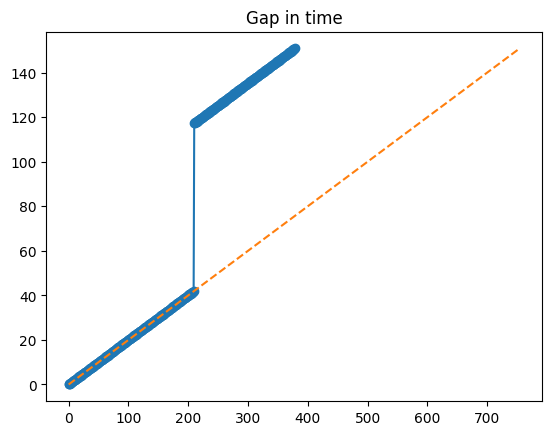

In [14]:
#| test
import matplotlib.pyplot as plt

psg_epoch = 30
n_epoch = 5
psg_max_time = psg_epoch * n_epoch
psg = np.array([
    [j, (j // psg_epoch) % (psg_max_time // 5)]
    for i, j in enumerate(range(0, psg_max_time, psg_epoch))
])

accel_sample_rate = 0.2
accel_time = np.arange(0, psg_max_time + 1, accel_sample_rate).reshape(-1, 1)
accel_xyz = np.random.random((len(accel_time), 3))
accel = np.hstack([accel_time, accel_xyz])

row_index = np.arange(accel.shape[0])


accel_mid_gap = accel.copy()
acc_time = accel[:, 0]

# starting at 1.4 epochs in (42 sec) there is a 2.5 epoch long gap. accel resumes at epoch 3.9, right before epoch 4
n_epoch_gap_starts = 1.4
n_epoch_gap_duration = 2.5

skip_seconds_start = psg_epoch * n_epoch_gap_starts
skip_seconds_end = skip_seconds_start + (psg_epoch * n_epoch_gap_duration)

gap_select = (acc_time < skip_seconds_start) | (acc_time > skip_seconds_end)
# (starting at epoch 0) this now has a gap during epochs 1, 2, 3 
# A,-,-,-,A
# A = accel present this epoch, - = at least 1/2 the epoch is missing
accel_mid_gap = accel_mid_gap[gap_select]

test_data = {
    "accelerometer": {
        "gap":  accel_mid_gap,
        "no_gap": accel
    },
    "psg": {
        "gap": psg.copy(),
        "no_gap": psg
    }
}

data_set = DataSetObject.from_dict(test_data)
plt.plot(accel_mid_gap[:, 0], 'o-')
plt.plot(acc_time, '--')
plt.title("Gap in time")
print("Pre-masking:")
print(psg)

psg_masked = mask_psg_from_accel(psg, accel_mid_gap)
print("MASKED:")
print(psg)


assert psg_masked[0, 1] == psg[0, 1], "first time stamp of PSG got masked"
assert np.all(psg_masked[1:4, 1] == -1), "gap time stamps of PSG did NOT get masked"
assert psg_masked[-1, 1] == psg[-1, 1], "first time stamp of PSG got masked"


In [15]:
#| test
input_vec = np.arange(10)
expected_rolling = np.array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])
rolled = rolling_window(input_vec, 3)


assert np.array_equal(rolled, expected_rolling), f"Expected {expected_rolling}, but got {rolled}"

In [16]:
#| export

import polars as pl
import numpy as np
from scipy.ndimage import gaussian_filter1d

def apply_gausian_filter(df: pl.DataFrame, sigma: float = 1.0, overwrite: bool = False) -> pl.DataFrame:
    data_columns = df.columns[1:]  # Adjust this to match your data column indices

    # Specify the standard deviation of the Gaussian kernel
    sigma = 1.0  # This controls the smoothing. Adjust based on your data's sampling rate and desired smoothing

    # Apply Gaussian smoothing to each data column
    for col in data_columns:
        new_col_name = f"{col}_smoothed" if not overwrite else col
        df = df.with_columns(
            pl.Series(gaussian_filter1d(df[col].to_numpy(), sigma)).alias(new_col_name)
        )
    return df

def fill_gaps_in_accelerometer_data(acc: pl.DataFrame, smooth: bool = False, final_sampling_rate_hz: int | None = None) -> np.ndarray:
    
    # median sampling rate (to account for missing data)
    sampling_period_s = acc[acc.columns[0]].diff().median() # 1 / sampling_rate_hz
    
    # Step 0: Save the original 'timestamp' column as 'timestamp_raw'
    acc_resampled = acc.with_columns(acc[acc.columns[0]].alias('timestamp'))

    if isinstance(final_sampling_rate_hz, int):
        final_rate_sec = 1 / final_sampling_rate_hz
        print(f"resampling to {final_sampling_rate_hz}Hz ({final_rate_sec:0.5f}s) from {int(1/sampling_period_s)} Hz ({sampling_period_s:0.5f}s)")
        # make a new data frame with the new timestamps
        # do this using linear interpolation

        median_time = acc_resampled['timestamp'].to_numpy()
        final_timestamps = np.arange(median_time.min(), median_time.max() + final_rate_sec, final_rate_sec)
        median_data = acc_resampled[:, 1:4].to_numpy()
        new_data = np.zeros((final_timestamps.shape[0], median_data.shape[1]))
        for i in range(median_data.shape[1]):
            new_data[:, i] = np.interp(final_timestamps, median_time, median_data[:, i])
        acc_resampled = pl.DataFrame({
            'timestamp': final_timestamps, 
            **{
                acc_resampled.columns[i+1]: new_data[:, i] 
                for i in range(new_data.shape[1])
            }})


    if smooth:
        acc_resampled = apply_gausian_filter(acc_resampled, overwrite=True)

    return acc_resampled


resampling to 50Hz (0.02000s) from 50 Hz (0.02000s)


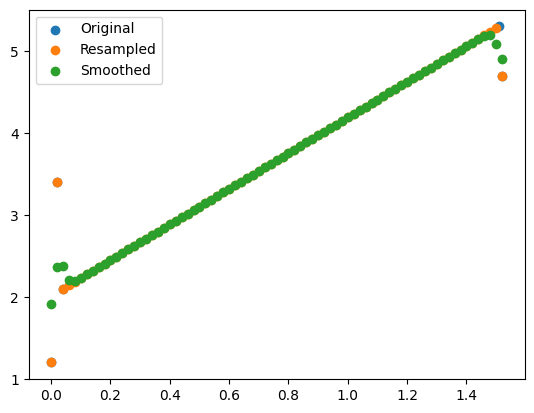

In [17]:
import matplotlib.pyplot as plt

# Assuming 'acc' is your existing Polars DataFrame with the first column as 'timestamp'.
acc = pl.DataFrame({
    "timestamp": [0, 0.02, 0.04, 1.51, 1.52],  # Irregular timestamps
    "sensor1": [1.2, 3.4, 2.1, 5.3, 4.7],
    "sensor2": [0.5, 0.8, 1.1, 0.3, 1.9]
})

acc_resampled = fill_gaps_in_accelerometer_data(acc, final_sampling_rate_hz=50)
acc_resampled = apply_gausian_filter(acc_resampled, overwrite=False)

# Plot the original and resampled timestamps
plt.scatter(acc['timestamp'], acc['sensor1'], label='Original')
plt.scatter(acc_resampled['timestamp'], acc_resampled['sensor1'], label='Resampled')
plt.scatter(acc_resampled['timestamp'], acc_resampled['sensor1_smoothed'], label='Smoothed')
plt.legend()

In [18]:
acc_resampled

timestamp,sensor1,sensor2,sensor1_smoothed,sensor2_smoothed
f64,f64,f64,f64,f64
0.0,1.2,0.5,1.908138,0.62661
0.02,3.4,0.8,2.360776,0.800721
0.04,2.1,1.1,2.377994,0.988355
0.06,2.143537,1.089116,2.212371,1.06949
0.08,2.187075,1.078231,2.19292,1.07677
…,…,…,…,…
1.44,5.147619,0.338095,5.147536,0.33831
1.46,5.191156,0.327211,5.188312,0.334542
1.48,5.234694,0.316327,5.198158,0.410174


In [19]:
# make a Gaussian-distributed random vector with 1000 elements
# mean zero, stdev 0.001

normal_vec = np.abs(np.random.normal(0.02, 0.001, 1000))
times = np.cumsum(normal_vec)

In [20]:
y = np.random.normal(0, 1, len(normal_vec))

In [21]:
df = pl.DataFrame({
    "timestamp": times,
    "y": y,
    "cos_y": np.cos(times),
})

In [22]:
df_r = fill_gaps_in_accelerometer_data(df, smooth=False, final_sampling_rate_hz=50)

resampling to 50Hz (0.02000s) from 49 Hz (0.02004s)


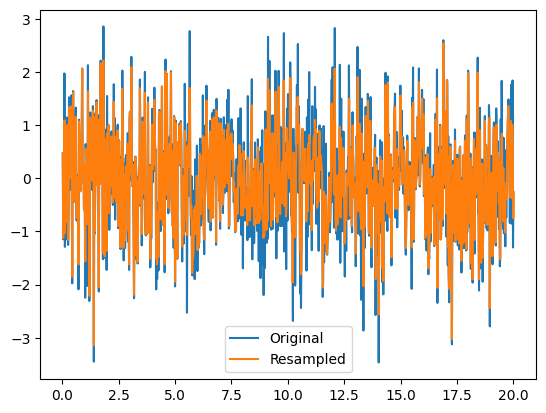

In [23]:
plt.plot(df['timestamp'], df['y'], label='Original')
plt.plot(df_r['timestamp'], df_r['y'], label='Resampled')
plt.legend()

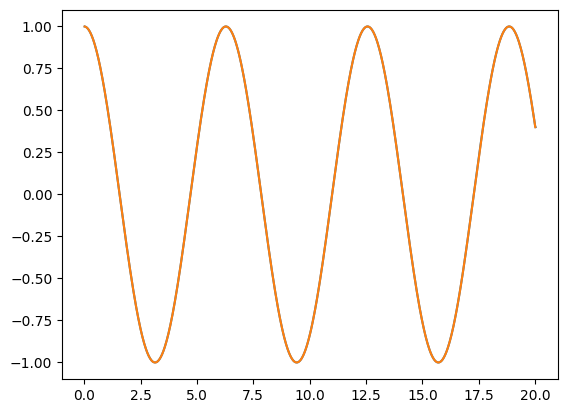

In [24]:
plt.plot(df_r['timestamp'], df_r['cos_y'], label='Resampled')
plt.plot(df['timestamp'], df['cos_y'], label='Original')

In [25]:
#| hide
import nbdev
nbdev.nbdev_export()